In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from keras.optimizers import SGD, Adam, RMSprop, Adamax, Adadelta
from keras.models import Model, load_model
from keras import Input, regularizers, initializers
from keras.layers import Dense, Dropout, Multiply, concatenate, LeakyReLU
from matplotlib import pyplot as plt
import keras.backend as K
from sklearn.preprocessing import StandardScaler, RobustScaler
from keras.utils.vis_utils import plot_model
from keras.callbacks import Callback
from sklearn.preprocessing import quantile_transform
import psycopg2
import missingno as msno
from pickle import dump, load

In [7]:
# Network Definition
def custom_loss(y_true,y_pred):
#         M * R * G
#         (1-w *R) * R * G
#         weights = y_pred[:,0]
#         g_i = y_pred[:,1]
#         excess_returns = y_true
#         M = 1-K.sum(weights * excess_returns)
        Return_true= y_true[:,27]
        Features = y_true[:,:27]
        Factors = y_pred
        prediction =K.sum(Features* Factors)
        
        
        #custom_loss_value = 1000*K.mean(((M * excess_returns)**2)* (g_i/K.sum(g_i)))
        custom_loss_value = K.mean((Return_true-prediction)**2)
        return custom_loss_value

def loss_arguments(Tickers, i):
    observation_weights =\
    Tickers["Count"].iloc[i*128:i*128+128]/\
    Tickers["Count"].iloc[i*128:i*128+128].sum()
    def custom_loss(y_true,y_pred):
        # M * R * G
        # (1-w *R) * R * G
        weights = y_pred[:,0]
        g_i = y_pred[:,1]
        excess_returns = y_true
        M = 1-K.sum(weights * excess_returns)
        custom_loss_value = K.mean(((M * excess_returns)**2)* g_i)
        return custom_loss_value
    return custom_loss_value


def custom_loss_adverse(y_true, y_pred):
    # M * R * G
    # (1-w *R) * R * G
    weights = y_pred[:,0]
    g_i = y_pred[:,1]
    excess_returns = y_true
    M = 1-K.sum(weights * excess_returns)
    custom_loss_value = -1000* K.mean(((M * excess_returns)**2)*(g_i/K.sum(g_i)))
    return custom_loss_value

class CustomCallback(Callback):
    def on_train_batch_end(self, batch, logs=None):
        global i
        global Tickers
        
        observation_weights_ =\
        Tickers["Count"].iloc[i*128:i*128+128]/\
        Tickers["Count"].iloc[i*128:i*128+128].sum()        
        i = i+1
        #print(observation_weights_)

In [38]:
input_shape = (27,)
network=None
opt=Adamax(lr=0.0001)
    
    
Input_object = Input(shape =input_shape, name='Input', dtype='float32')
Dense1 = Dense(50, activation='relu', name='Dense1',\
                kernel_initializer=initializers.Zeros(),\
               input_shape=input_shape)(Input_object)
Dropout1= Dropout(0.05)(Dense1)
Dense2 = Dense(30, activation='relu', name='Dense2',\
                kernel_initializer=initializers.Zeros())(Dropout1)
Out = Dense(1, activation='sigmoid', name='Output',\
                kernel_initializer=initializers.Zeros())(Dense2)
#LeakyReLU

# # kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
# #     bias_regularizer=regularizers.l2(1e-4),
# #     activity_regularizer=regularizers.l2(1e-5)
# G_1 = Dense(50, activation='sigmoid', name='G_1',\
#             input_shape=input_shape)(Input_object)

# # Sigmoid works
# G_2 = Dense(1, activation='sigmoid', name='G_2')(G_1)

#Out = concatenate([Dense3, G_2], name='Output')

network = Model([Input_object], Out)

In [9]:
# database cols: needed only once

conn = psycopg2.connect("dbname=Kelly_2017_2020 user=postgres password=fussball1")
cur = conn.cursor()

cur.execute("SELECT column_name from information_schema.columns WHERE (table_name = 'data');")
column_names = cur.fetchall()
print("got column_names")

cur.execute("SELECT column_name from information_schema.columns WHERE (table_name = 'macro');")
macro_column_names = cur.fetchall()
print("got macro_column_names")

cur.execute("SELECT * From macro;")
macro_data = cur.fetchall()
macro_data = pd.DataFrame(macro_data, columns=pd.DataFrame(macro_column_names)[0])

print("got macro_data")

conn.commit()
cur.close()
conn.close()

date_list = macro_data["eom"]
date_list=date_list.sort_values()

got column_names
got macro_column_names
got macro_data


In [10]:
# database cols: needed only once

conn = psycopg2.connect("dbname=Kelly_2017_2020 user=postgres password=fussball1")
cur = conn.cursor()

cur.execute("SELECT column_name from information_schema.columns WHERE (table_name = 'data');")
column_names = cur.fetchall()
print("got column_names")

cur.execute("SELECT column_name from information_schema.columns WHERE (table_name = 'macro');")
macro_column_names = cur.fetchall()
print("got macro_column_names")

# cur.execute("SELECT * From macro;")
# macro_data = cur.fetchall()
# macro_data = pd.DataFrame(macro_data, columns=pd.DataFrame(macro_column_names)[0])

#print("got macro_data")

#conn.commit()
cur.close()
conn.close()


got column_names
got macro_column_names


In [6]:
# NO! just dont import macro

# variables=pd.read_excel("C:\\Users\\Vincent\\01 Python_Working_Directory\\Master\\Test\\Data\\Data Fabio\\Output\\variables.xlsx",\
#                   sheet_name = "variables", usecols = "A:B")
# identifiers=variables[(variables["TYPE"]=="identifier") | (variables["TYPE"]=="observation identifier")]
# identifiers=list(identifiers["VARIABLE"])

# column_df=pd.read_csv("C:\\Users\\Vincent\\01 Python_Working_Directory\\Master\\Test\\Data\\Data Fabio\\Output\\example_sample.csv",\
#                   index_col=0)
# cols = column_df.columns.values
# delete_cols_median =[]
# for col in cols:
#         if not col in identifiers:
#             delete_cols_median.append(col+"_median")
            
#val_batch.drop(columns=delete_cols_median, inplace = True)

In [11]:
variables=pd.read_excel("C:\\Users\\Vincent\\01 Python_Working_Directory\\Master\\Test\\Data\\Data Fabio\\Output\\variables_small.xlsx",\
                  sheet_name = "variables", usecols = "A:B")
identifiers=variables[(variables["TYPE"]=="identifier") | (variables["TYPE"]=="observation identifier")]
identifiers=list(identifiers["VARIABLE"])
identifiers.remove("eom")

delete_cols = pd.read_csv("Networks\delete_cols.csv")
delete_cols =delete_cols["0"]

In [12]:
# delete_cols = val_batch.loc[:,val_batch.isna().sum()>val_batch.isna().sum().quantile(0.1)].columns.values
# pd.DataFrame(delete_cols).to_csv("Networks\delete_cols.csv", index = False)

In [13]:
len(delete_cols)

342

In [14]:
keep_variables=pd.read_excel("C:\\Users\\Vincent\\01 Python_Working_Directory\\Master\\Networks\\kept_columns.xlsx",\
                  sheet_name = "filtered", usecols = "A:A", index=False)

In [15]:
keep_variables_list =[]
for var in keep_variables["Kelly"]:
    keep_variables_list.append(var,)

In [16]:
for i in list(["inv", "xsga", "at", \
               "beta_zd", "ivol_capm_zd",\
               "turnover_zd", "beta_60m",\
               "prc_highprc_252d","bidaskhl_21d",\
              "dolvol_var_zd","VARC_z(X)"]):
    keep_variables_list.remove(i)

In [17]:
str(date_list[15])

'20970.0'

In [18]:
# once only to save time
conn = psycopg2.connect("dbname=Kelly_2017_2020 user=postgres password=fussball1")
cur = conn.cursor()

cur.execute("SELECT * FROM data WHERE eom = '"+str(date_list[15])+"';")
val_batch = cur.fetchall()
cur.close()
conn.close()

val_batch = pd.DataFrame(val_batch, columns = pd.DataFrame(column_names)[0])

val_batch.replace("EMPTY", np.nan, inplace = True)

val_batch.drop(columns=identifiers, inplace = True)
val_batch = val_batch[False == val_batch["ret_exc_lead1m"].isnull()]

# select indexes to drop
quantile_0999=val_batch[["ret_exc_lead1m"]].astype(float).quantile(0.999)[0]
drop_indexes = val_batch.index[(val_batch[["ret_exc_lead1m"]].astype(float)>quantile_0999)["ret_exc_lead1m"]]
val_batch.drop(drop_indexes, inplace = True)

In [21]:
pd.DataFrame(pd.qcut(val_batch["me"].astype(float), 20))["me"].rank(pct=True)

2        0.025052
3        0.025052
4        0.025052
45       0.025052
47       0.175049
           ...   
22697    0.775005
22699    0.125039
22700    0.975011
22701    0.975011
22702    0.875024
Name: me, Length: 15939, dtype: float64

In [19]:
val_batch_short = val_batch[keep_variables_list]

# lösche Zeile mit mehr als x% leer: 0.1 _> behalte 40%
drop_indexes_nan = val_batch_short.index[(val_batch_short.isna().mean(axis=1)>0.1)]
val_batch_short.drop(drop_indexes_nan, inplace = True)

# fillna more complicated than usual??
val_batch_short = pd.DataFrame(val_batch[keep_variables_list])
val_batch_short=val_batch_short.fillna(val_batch_short.median())

C:\Users\Vincent\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [20]:
X_val_batch = val_batch_short.drop(columns=['ret_exc_lead1m','eom'])
X_val_batch=X_val_batch.astype(float)
for col in X_val_batch.columns.values:
#     X_val_batch[col].update(X_val_batch[col].rank(pct=True))
    X_val_batch[col].update(pd.qcut(X_val_batch[col].astype(float).rank(pct=True, method="first"), 20).rank(pct=True))

Y_val_batch = val_batch_short["ret_exc_lead1m"].astype(float)

In [25]:
# Y_val_batch.update(Y_val_batch.rank(pct=True))

In [30]:
Y_val_batch.update(((Y_val_batch>0.0065)*1))

In [28]:
Y_val_batch.median()

0.008003689655172376

0.5196687370600414

In [23]:
Y_val_batch.mean()

0.015995379602322057

In [13]:
# pd.DataFrame(val_batch.columns.values).to_csv("Networks\\kept_columns.csv")

In [592]:
scaler = RobustScaler(with_centering=True, with_scaling=True,quantile_range=(0.01,0.99)).fit(val_batch_short.drop(columns=['ret_exc_lead1m']))

In [580]:
val_batch_short.drop("eom", axis=1, inplace =True)

In [707]:
# dump(scaler, open('Networks\\scaler_short.pkl','wb'))

In [609]:
scaler = load(open('Networks\\scaler_short.pkl','rb'))

In [610]:
val_batch=None
X_val_batch=None
Y_val_batch=None
val_batch_short = None

0.022727272727272728
got data
Train on 15942 samples, validate on 15939 samples
Epoch 1/100
15942/15942 [==============================] - 1s 41us/step - loss: 0.6780 - val_loss: 0.7029
Epoch 2/100
15942/15942 [==============================] - 0s 25us/step - loss: 0.6763 - val_loss: 0.7031
Epoch 3/100
15942/15942 [==============================] - 0s 24us/step - loss: 0.6763 - val_loss: 0.7040
Epoch 4/100
15942/15942 [==============================] - 0s 22us/step - loss: 0.6763 - val_loss: 0.7022
Epoch 5/100
15942/15942 [==============================] - 0s 23us/step - loss: 0.6763 - val_loss: 0.7012
Epoch 6/100
15942/15942 [==============================] - 0s 22us/step - loss: 0.6763 - val_loss: 0.7011
Epoch 7/100
15942/15942 [==============================] - 0s 21us/step - loss: 0.6764 - val_loss: 0.7037
Epoch 8/100
15942/15942 [==============================] - 0s 21us/step - loss: 0.6763 - val_loss: 0.7017
Epoch 9/100
15942/15942 [==============================] - 0s 22us/step 

15942/15942 [==============================] - 0s 24us/step - loss: 0.6763 - val_loss: 0.7007
Epoch 77/100
15942/15942 [==============================] - 0s 21us/step - loss: 0.6763 - val_loss: 0.7026
Epoch 78/100
15942/15942 [==============================] - 0s 22us/step - loss: 0.6763 - val_loss: 0.7065
Epoch 79/100
15942/15942 [==============================] - 0s 22us/step - loss: 0.6763 - val_loss: 0.7031
Epoch 80/100
15942/15942 [==============================] - 0s 23us/step - loss: 0.6762 - val_loss: 0.7073
Epoch 81/100
15942/15942 [==============================] - 0s 22us/step - loss: 0.6764 - val_loss: 0.7035
Epoch 82/100
15942/15942 [==============================] - 0s 22us/step - loss: 0.6763 - val_loss: 0.7015
Epoch 83/100
15942/15942 [==============================] - 0s 22us/step - loss: 0.6764 - val_loss: 0.7048
Epoch 84/100
15942/15942 [==============================] - 0s 24us/step - loss: 0.6763 - val_loss: 0.7010
Epoch 85/100
15942/15942 [========================

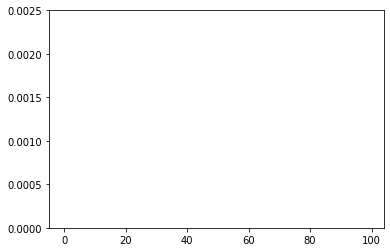

0.9998881648150645 1.0005135942413235
Train on 15942 samples, validate on 15939 samples
Epoch 1/100
15942/15942 [==============================] - 1s 33us/step - loss: 0.6767 - val_loss: 0.7055
Epoch 2/100
15942/15942 [==============================] - 0s 21us/step - loss: 0.6765 - val_loss: 0.7011
Epoch 3/100
15942/15942 [==============================] - 0s 21us/step - loss: 0.6764 - val_loss: 0.7041
Epoch 4/100
15942/15942 [==============================] - 0s 25us/step - loss: 0.6763 - val_loss: 0.7061
Epoch 5/100
15942/15942 [==============================] - 0s 22us/step - loss: 0.6763 - val_loss: 0.7063
Epoch 6/100
15942/15942 [==============================] - 0s 22us/step - loss: 0.6764 - val_loss: 0.7009
Epoch 7/100
15942/15942 [==============================] - 0s 21us/step - loss: 0.6763 - val_loss: 0.7028
Epoch 8/100
15942/15942 [==============================] - 0s 28us/step - loss: 0.6763 - val_loss: 0.7019
Epoch 9/100
15942/15942 [==============================] - 0s 22

15942/15942 [==============================] - 0s 23us/step - loss: 0.6762 - val_loss: 0.7020
Epoch 77/100
15942/15942 [==============================] - 0s 24us/step - loss: 0.6762 - val_loss: 0.7073
Epoch 78/100
15942/15942 [==============================] - 0s 22us/step - loss: 0.6764 - val_loss: 0.7022
Epoch 79/100
15942/15942 [==============================] - 0s 21us/step - loss: 0.6763 - val_loss: 0.7046
Epoch 80/100
15942/15942 [==============================] - 0s 22us/step - loss: 0.6763 - val_loss: 0.7047
Epoch 81/100
15942/15942 [==============================] - 0s 22us/step - loss: 0.6762 - val_loss: 0.7012
Epoch 82/100
15942/15942 [==============================] - 0s 23us/step - loss: 0.6763 - val_loss: 0.7049
Epoch 83/100
15942/15942 [==============================] - 0s 21us/step - loss: 0.6763 - val_loss: 0.7029
Epoch 84/100
15942/15942 [==============================] - 0s 22us/step - loss: 0.6763 - val_loss: 0.7015
Epoch 85/100
15942/15942 [========================

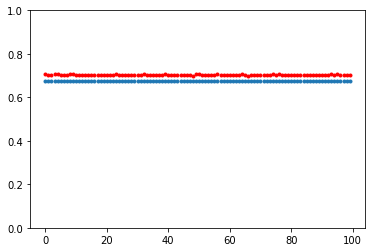

0.9999212272059459 0.999093700917942
0.045454545454545456
got data


KeyboardInterrupt: 

In [39]:
i = 0

g_sort = []
for date in date_list:
    i+=1
    print(i/len(date_list))
    
    # import Dataset
    # pull random draws
    conn = psycopg2.connect("dbname=Kelly_2017_2020 user=postgres password=fussball1")
    cur = conn.cursor()

    cur.execute("SELECT * FROM data WHERE eom = '"+str(date)+"';")
    train_batch = cur.fetchall()
    print("got data")

    cur.close()
    conn.close()

    train_batch = pd.DataFrame(train_batch, columns = pd.DataFrame(column_names)[0])
    
    
    #preprocess
    train_batch.replace("EMPTY", np.nan, inplace = True)
    
    
    #train_batch = train_batch[keep_variables_list]

    # lösche Zeile mit mehr als x% leer: 0.1 _> behalte 40%
    #drop_indexes_nan = train_batch.index[(train_batch.isna().mean(axis=1)>0.1)]
    #train_batch.drop(drop_indexes_nan, inplace = True)

    # short selection
    train_batch = pd.DataFrame(train_batch[keep_variables_list])
    train_batch = train_batch[False == train_batch["ret_exc_lead1m"].isnull()]
    train_batch=train_batch.fillna(train_batch.median())
    # shuffle!
    train_batch=train_batch.sample(frac=1)
    
    
    
    # drop outliers in Y
    quantile_0999=train_batch[["ret_exc_lead1m"]].astype(float).quantile(0.999)[0]
    drop_indexes = train_batch.index[(train_batch[["ret_exc_lead1m"]].astype(float)>quantile_0999)["ret_exc_lead1m"]]
    train_batch.drop(drop_indexes, inplace = True)

    


    # not in loop, only once! define delete_cols after text conversion
    #used once only
    #train_batch.loc[:,train_batch.isna().sum()>train_batch.isna().sum().quantile(0.1)].columns.values

    
    #np.savetxt("Networks\delete_cols.csv", delete_cols, delimiter=",")
    # join macro
    #train_batch = pd.merge(train_batch,macro_data, on ="eom")
    train_batch.drop(columns=["eom"], inplace = True)
    X_train_batch = train_batch.drop(columns=['ret_exc_lead1m'])
    X_train_batch=X_train_batch.astype(float)
    for col in X_train_batch.columns.values:
        #X_train_batch[col].update(X_train_batch[col].rank(pct=True))
        X_train_batch[col].update(pd.qcut(X_train_batch[col].rank(pct=True, method = 'first'), 50).rank(pct=True))
        
    # choose fillna or drop na
    X_train_batch.fillna(X_train_batch.median(), inplace=True)
    #X_train_batch=X_train_batch.loc[False==train_batch.isna().any(axis=1),:]
   
    
    # transform back to DF to make fillna possible
    X_train_batch=pd.DataFrame(X_train_batch)
    
    # choose fillna or drop na
    Y_train_batch = train_batch['ret_exc_lead1m'].astype(float)
    Y_train_batch.update(((Y_train_batch>0.0065)*1))
    #Y_train_batch.update(pd.qcut(Y_train_batch.rank(pct=True, method = 'first'), 50).rank(pct=True))
    #Y_train_batch = Y_train_batch.loc[False==train_batch.isna().any(axis=1)]
    
    train_batch = None
    
    # optimizer
    batch_size = 120
    num_epochs = 100
    opt=Adam(learning_rate = 0.01)
    # turn on discriminator
#     network.layers[1].trainable = True
#     network.layers[2].trainable = True
#     network.layers[3].trainable = True
#     network.layers[5].trainable = True
#     network.layers[7].trainable = True

#     # turn of adverse
#     network.layers[4].trainable = False
#     network.layers[6].trainable = False

    network.compile(optimizer=opt,\
                       loss="binary_crossentropy")
    history=network.fit(X_train_batch, Y_train_batch, \
                        epochs=num_epochs, batch_size=batch_size, validation_data=(X_val_batch, Y_val_batch))
    plt.plot(history.history["loss"], marker = ".",linestyle='None', color = "b")
    plt.plot(history.history["val_loss"], marker = ".",linestyle='None', color ="r")
    plt.ylim(0,0.0025)
    plt.show()
    decrease_loss = np.array(history.history["loss"][-20:]).mean()/np.array(history.history["loss"][:20]).mean()
    decrease_loss_val = np.array(history.history["val_loss"][-20:]).mean()/np.array(history.history["val_loss"][:20]).mean()
    print(decrease_loss, decrease_loss_val)
    
#     w=network.predict(X_train_batch)
#     plt.hist(w[:,1])
#     w=network.predict(X_val_batch)
#     plt.hist(w[:,1])
#     plt.show()
    
#     # Adversarial
#     num_epochs = 100
#     # turn of discriminator
#     network.layers[1].trainable = False
#     network.layers[2].trainable = False
#     network.layers[3].trainable = False
#     network.layers[5].trainable = False
#     network.layers[7].trainable = False

#     # turn on adverse
#     network.layers[4].trainable = True
#     network.layers[6].trainable = True

#     network.compile(optimizer=opt,\
#                        loss=custom_loss_adverse)
#     history=network.fit(X_train_batch, Y_train_batch, epochs=num_epochs, batch_size=batch_size)
#     plt.plot(history.history["loss"], marker = "x",linestyle='None')
#     plt.show()
#     decrease_loss = np.array(history.history["loss"][-20:]).mean()/np.array(history.history["loss"][:20]).mean()
#     print(decrease_loss)
    
#     w=network.predict(X_train_batch)
#     plt.hist(w[:,1])
#     w=network.predict(X_val_batch)
#     plt.hist(w[:,1])
#     plt.show()
    
#     w=network.predict(X_train_batch)
#     low = X_train_batch.iloc[w[:,1]<np.quantile(w[:,1], 0.2)].describe().iloc[[1]]
#     high= X_train_batch.iloc[w[:,1]>np.quantile(w[:,1], 0.8)].describe().iloc[[1]]
#     g_sort.append((high/low).iloc[0].sort_values())


    
    
    # optimizer again
    num_epochs = 100
    # turn on discriminator
#     network.layers[1].trainable = True
#     network.layers[2].trainable = True
#     network.layers[3].trainable = True
#     network.layers[5].trainable = True
#     network.layers[7].trainable = True

#     # turn of adverse
#     network.layers[4].trainable = False
#     network.layers[6].trainable = False

    network.compile(optimizer=opt,\
                       loss="binary_crossentropy")
    history=network.fit(X_train_batch, Y_train_batch, \
                        epochs=num_epochs, batch_size=batch_size,\
                        validation_data=(X_val_batch, Y_val_batch))
            
    plt.plot(history.history["loss"], marker = ".",linestyle='None')
    plt.plot(history.history["val_loss"], marker = ".",linestyle='None', color ="r")
    plt.ylim(0,1)
    plt.show()
    decrease_loss = np.array(history.history["loss"][-20:]).mean()/np.array(history.history["loss"][:20]).mean()
    decrease_loss_val = np.array(history.history["val_loss"][-20:]).mean()/np.array(history.history["val_loss"][:20]).mean()
    print(decrease_loss, decrease_loss_val)

    X_train_batch = None
    Y_train_batch = None

In [33]:
len(Y_train_batch.unique())

15447

(array([1595., 1594., 1594., 1594., 1594., 1594., 1594., 1594., 1594.,
        1595.]),
 array([6.27273868e-05, 1.00056455e-01, 2.00050182e-01, 3.00043909e-01,
        4.00037636e-01, 5.00031364e-01, 6.00025091e-01, 7.00018818e-01,
        8.00012545e-01, 9.00006273e-01, 1.00000000e+00]),
 <a list of 10 Patch objects>)

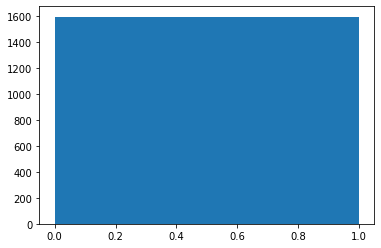

In [213]:
plt.hist(X_train_batch[col].rank(pct=True, method = 'first'))

In [178]:
pd.qcut(X_train_batch[col].rank(pct=True, method='first'), 10).unique()

[(0.3, 0.4], (-0.0009373000000000001, 0.1], (0.6, 0.7], (0.2, 0.3], (0.8, 0.9], (0.1, 0.2], (0.7, 0.8], (0.9, 1.0], (0.4, 0.5], (0.5, 0.6]]
Categories (10, interval[float64]): [(-0.0009373000000000001, 0.1] < (0.1, 0.2] < (0.2, 0.3] < (0.3, 0.4] ... (0.6, 0.7] < (0.7, 0.8] < (0.8, 0.9] < (0.9, 1.0]]

In [132]:
X_train_batch["me"]

7057     0.625016
4562     0.924978
8235     0.774997
19728    0.824991
8991     0.625016
           ...   
4680     0.475662
21227    0.025060
18765    0.575022
5927     0.625016
19356    0.475662
Name: me, Length: 15942, dtype: float64

In [36]:
Y_train_batch.

6044     0.025753
11547   -0.045506
4149     0.037977
17803    0.017335
2854    -0.032908
           ...   
6196     0.004506
21670    0.150295
3790    -0.056816
11265   -0.026338
22222    0.000619
Name: ret_exc_lead1m, Length: 6350, dtype: float64

In [321]:
network.save('Networks\prototype_09_weight_adj_datesort.h5')

In [245]:
pd.DataFrame(g_sort)

""


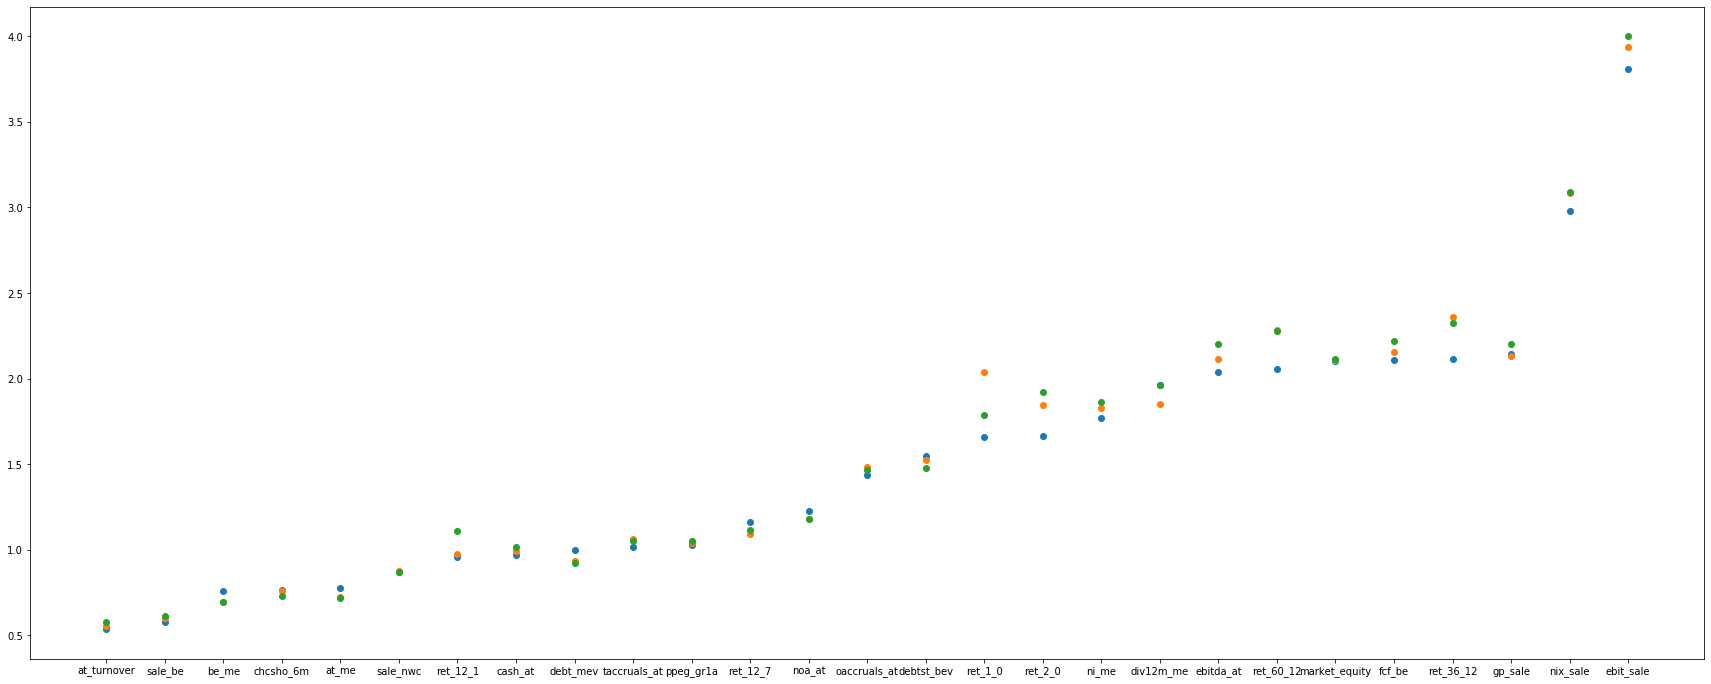

In [322]:
plt.figure(figsize=(30,12))
for i in range (pd.DataFrame(g_sort).shape[0]):
    plt.plot(pd.DataFrame(g_sort).iloc[i], linestyle='None', marker = 'o')

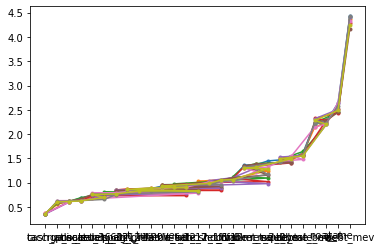

In [192]:
for i in g_sort:
    plt.plot(i, marker = ".", linestyle=None)

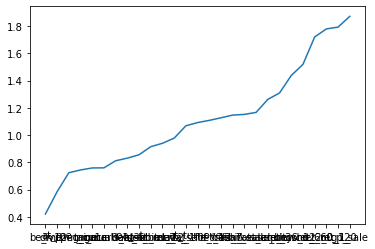

In [155]:
plt.plot(g_sort[0])

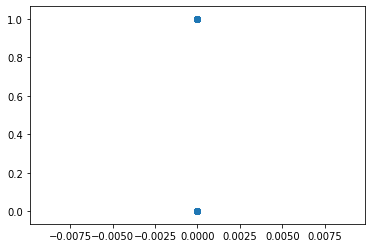

In [40]:
plt.scatter(y_pred, Y_val_batch)

In [43]:
pd.DataFrame(y_pred).max()

0    0.0
dtype: float32

In [45]:
y_pred

array([[0.5836641],
       [0.5836641],
       [0.5836641],
       ...,
       [0.5836641],
       [0.5836641],
       [0.5836641]], dtype=float32)

In [44]:
y_pred=network.predict(X_val_batch)

In [217]:
Y_val_batch.mean()

0.015995379602322057

In [29]:
y_pred

array([[0.51472867],
       [0.51472867],
       [0.51472867],
       ...,
       [0.51472867],
       [0.51472867],
       [0.51472867]], dtype=float32)

(array([1.700e+01, 3.000e+01, 1.530e+02, 9.611e+03, 5.848e+03, 2.040e+02,
        4.200e+01, 1.500e+01, 1.000e+01, 9.000e+00]),
 array([-1.00046994, -0.74560769, -0.49074543, -0.23588318,  0.01897907,
         0.27384133,  0.52870358,  0.78356583,  1.03842809,  1.29329034,
         1.54815259]),
 <a list of 10 Patch objects>)

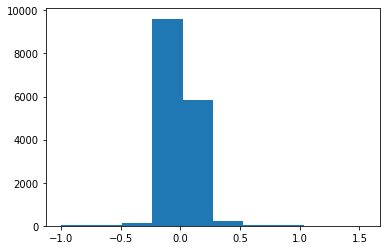

In [80]:
plt.hist(Y_val_batch["ret_exc_lead1m"])

(array([  20.,  181.,  654., 1519., 2421., 3525., 4082., 3029.,  491.,
          17.]),
 array([ 1.75494259,  2.62345338,  3.49196416,  4.36047495,  5.22898573,
         6.09749652,  6.9660073 ,  7.83451808,  8.70302887,  9.57153965,
        10.44005044]),
 <a list of 10 Patch objects>)

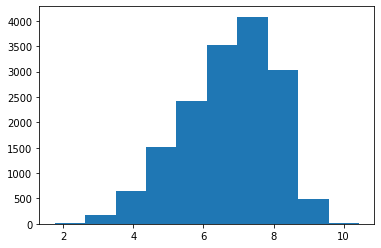

In [215]:
plt.hist((y_pred*X_val_batch).sum(axis=1))

In [214]:
y_pred=network.predict(X_val_batch)
y_pred[:,0].min()/y_pred[:,0].max()

1.0

In [324]:
# 1-w*R is the SDF
(1-sum(y_pred[:,0]*Y_val_batch))

0.2820917225264813

In [325]:
# Loss1 on val
# M * R
# (1-w *R) * R 
w=network.predict(X_val_batch)
np.mean(((1-sum(w[:,0]*Y_val_batch)))*Y_val_batch)

0.0045121641844844285

In [326]:
# Loss1
# M * R
# (1-w *R) * R 
w=network.predict(X_train_batch)
np.mean(((1-sum(w[:,0]*Y_train_batch)))*Y_train_batch)

0.0006505739464330899

In [327]:
w[:,1].shape

(6281,)

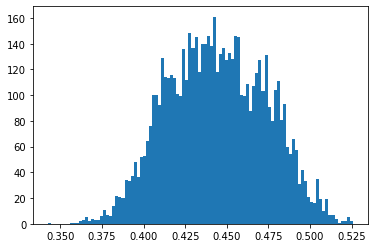

In [328]:
xx=plt.hist(w[:,1], bins =100)

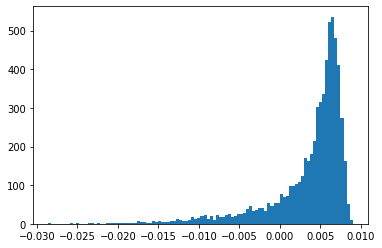

In [329]:
ploot=plt.hist(w[:,0], bins = 100)

In [340]:
# Loss2
# M * R * G
# (1-w *R) * R * G
w=network.predict(X_val_batch)
np.mean(((1-sum(w[:,0]*Y_val_batch)) )*Y_val_batch*w[:,1])

0.001991606085866607

In [343]:
len(X_train_batch)/1000

6.281

In [353]:
Return_List = []
for i in range(0,15):
    w=network.predict(X_val_batch.iloc[0+i*1000:1000+i*1000])
    Return_List.append(sum(w[:,0]*Y_val_batch.iloc[0+i*1000:1000+i*1000]))
(np.array(Return_List).mean()/np.array(Return_List).std())

1.2474293947214217

In [333]:
date

'20909.0'

In [354]:
Return_List = []
for i in range(0,6):
    w=network.predict(X_train_batch.iloc[0+i*1000:1000+i*1000])
    Return_List.append(sum(w[:,0]*Y_train_batch.iloc[0+i*1000:1000+i*1000]))
(np.array(Return_List).mean()/np.array(Return_List).std())

6.151754184902421

In [345]:
Y_train_batch.mean()

0.0027414196581666537

In [350]:
len(Y_val_batch)

15939

In [355]:
Return_List_BH = []
for i in range(0,15):
    Return_List_BH.append(Y_val_batch.iloc[0+i*1000:1000+i*1000])

np.array(Return_List_BH)[0].mean()/np.array(Return_List_BH)[0].std()

0.11850503947761944

In [356]:
Return_List_BH = []
for i in range(0,6):
    Return_List_BH.append(Y_train_batch.iloc[0+i*1000:1000+i*1000])

np.array(Return_List_BH)[0].mean()/np.array(Return_List_BH)[0].std()

0.02404803143678757

In [283]:
# MSCI monthly sharpe
0.7/np.sqrt(12)

0.20207259421636903

In [ ]:
Y_val_batch.mean()/Y_val_batch.std()

In [220]:
# /w[:,0].sum() to adjust for weight sum <1 -> ptf of 100%
((w[:,0]/w[:,0].sum())*y_features_set).sum()

# annualized
(((w[:,0]/w[:,0].sum())*y_features_set).sum()+1)**3-1

NameError: name 'y_features_set' is not defined

In [ ]:
# return
print((w[:,0]*Y_val_batch).sum())

# sum of weights
print(w[:,0].sum())

In [ ]:
tt=plt.hist(w[:,0], bins = 100, range=(0.0003, 0.0004))

In [ ]:
epochs = range(1, len(acc[0]) + 1)
colorlist = ['blue','cyan','purple','pink','orange','red','brown','gray','olive','green']
plt.figure(figsize=(12,6))
i=0
while i <  len(acc):
    plt.plot(epochs, acc[i] , 'bo', label='Training acc', color = colorlist[i])
    plt.plot(epochs, val_acc[i], 'b', label='Validation acc', color=colorlist[i])
    
    ax= plt.gca()
    ax.tick_params(direction='in')
    i+=1
#plt.ylim(ymax = 1, ymin = 0.6)
plt.title('Training and validation accuracy')

In [ ]:
network.predict(X)[:,0]

In [ ]:
weights = network.predict(X)[:,0]
g_i = network.predict(X)[:,1]
excess_returns = Y
(weights * excess_returns).mean()

In [ ]:
np.array(network.layers[3].get_weights()[0])[:,0].shape

In [ ]:
plt.plot(network.layers[3].get_weights()[0][:,0])

In [193]:
model = load_model('Networks\prototype_07_pctrnk_tanh_gan_constant.h5', custom_objects={'custom_loss': custom_loss} )